In [1]:
import os
import numpy as np
import cv2
import pydicom
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

C:\Users\DFELL\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [ ]:
# Define dataset path
dataset_path = ""

# Define image size and number of classes
IMG_SIZE = 128
NUM_CLASSES = 4  # Glioma, Meningioma, No Tumor, Pituitary

In [3]:
def load_dataset(dataset_path):
    X, y = [], []
    class_labels = os.listdir(dataset_path)
    label_map = {label: i for i, label in enumerate(class_labels)}
    
    for label in class_labels:
        label_path = os.path.join(dataset_path, label)
        for filename in os.listdir(label_path):
            file_path = os.path.join(label_path, filename)
            if filename.endswith(".dcm"):
                dicom_data = pydicom.dcmread(file_path)
                img = dicom_data.pixel_array
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                img = img / 255.0  # Normalize
                X.append(img)
                y.append(label_map[label])
    
    X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    y = to_categorical(y, NUM_CLASSES)
    return X, y, class_labels

In [4]:
# Load data
X, y, class_labels = load_dataset(dataset_path)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [6]:
# Train model
model = build_model()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

Epoch 1/20
143/143 [==============================] - 107s 716ms/step - loss: 0.8249 - accuracy: 0.6538 - val_loss: 0.4713 - val_accuracy: 0.8136
Epoch 2/20
143/143 [==============================] - 99s 692ms/step - loss: 0.4806 - accuracy: 0.8236 - val_loss: 0.3233 - val_accuracy: 0.8705
Epoch 3/20
143/143 [==============================] - 92s 642ms/step - loss: 0.3702 - accuracy: 0.8619 - val_loss: 0.2888 - val_accuracy: 0.8810
Epoch 4/20
143/143 [==============================] - 91s 638ms/step - loss: 0.3054 - accuracy: 0.8877 - val_loss: 0.2282 - val_accuracy: 0.9108
Epoch 5/20
143/143 [==============================] - 90s 630ms/step - loss: 0.2428 - accuracy: 0.9166 - val_loss: 0.2433 - val_accuracy: 0.9055
Epoch 6/20
143/143 [==============================] - 91s 639ms/step - loss: 0.2167 - accuracy: 0.9210 - val_loss: 0.2309 - val_accuracy: 0.9274
Epoch 7/20
143/143 [==============================] - 92s 645ms/step - loss: 0.1723 - accuracy: 0.9372 - val_loss: 0.2170 - val_a

In [7]:
# Save model
model.save("brain_tumor_custom_cnn.h5")

C:\Users\DFELL\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
# Evaluate model
def evaluate_model(model, X_test, y_test):
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

In [10]:
evaluate_model(model, X_test, y_test)

36/36 [==============================] - 3s 90ms/step - loss: 0.2962 - accuracy: 0.9405
Test Accuracy: 94.05%


1/1 [==============================] - 0s 39ms/step


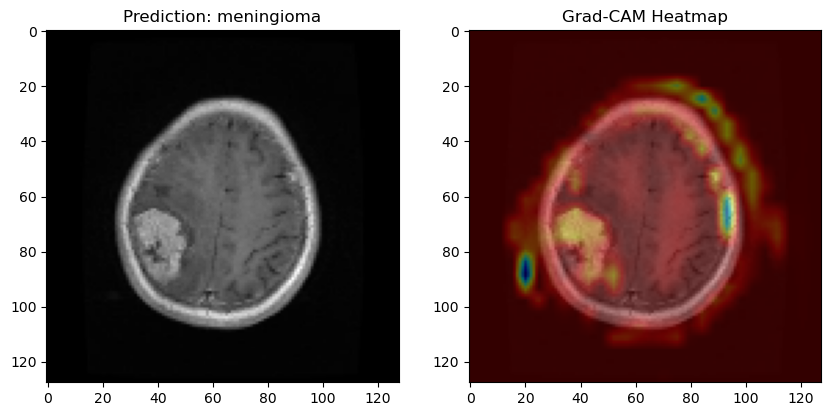

Predicted Diagnosis: meningioma


In [16]:
# Grad-CAM for visualization
def get_gradcam_heatmap(model, img_array, layer_name="conv2d_2"):
    grad_model = tf.keras.models.Model([model.input], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, np.argmax(predictions)]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)[0].numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

# Overlay heatmap
def overlay_heatmap(original_img, heatmap):
    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_GRAY2RGB)  # Convert grayscale to RGB
    overlayed_img = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)
    return overlayed_img

# Prediction function
def get_prediction(img_path):
    dicom_data = pydicom.dcmread(img_path)
    img = dicom_data.pixel_array
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img_array = np.expand_dims(img, axis=(0, -1))
    
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)
    diagnosis = class_labels[predicted_class]
    
    heatmap = get_gradcam_heatmap(model, img_array)
    heatmap_img = overlay_heatmap((img * 255).astype(np.uint8), heatmap)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Prediction: {diagnosis}")
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap_img)
    plt.title("Grad-CAM Heatmap")
    plt.show()
    return diagnosis

# Example usage
img_path = "Tr-me_0011.dcm"
prediction = get_prediction(img_path)
print(f"Predicted Diagnosis: {prediction}")

1/1 [==============================] - 0s 48ms/step


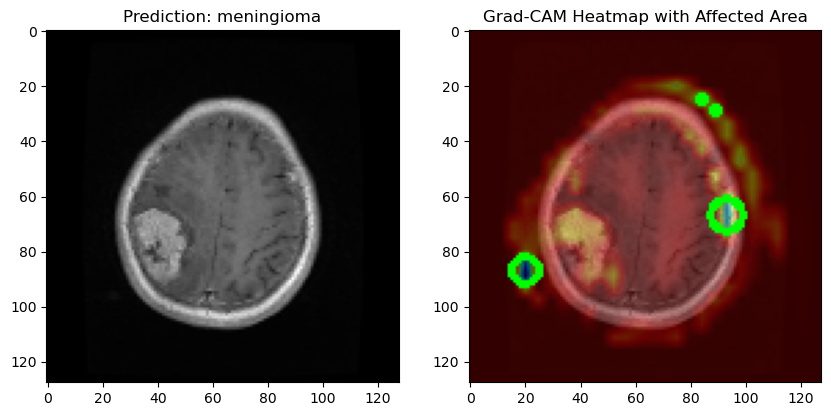

Suggested Action: Consult a medical professional for further guidance.
Predicted Diagnosis: meningioma


In [22]:
# Grad-CAM for visualization
def get_gradcam_heatmap(model, img_array, layer_name="conv2d_2"):
    grad_model = tf.keras.models.Model([model.input], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, np.argmax(predictions)]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)[0].numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

# Overlay heatmap and draw circle around affected area
def overlay_heatmap(original_img, heatmap):
    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_GRAY2RGB)  # Convert grayscale to RGB
    overlayed_img = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)
    
    # Convert heatmap to grayscale for contour detection
    gray_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray_heatmap, 200, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        cv2.circle(overlayed_img, (x + w // 2, y + h // 2), max(w, h) // 2, (0, 255, 0), 2)
    
    return overlayed_img

# Prediction function with suggestions
def get_prediction(img_path):
    dicom_data = pydicom.dcmread(img_path)
    img = dicom_data.pixel_array
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img_array = np.expand_dims(img, axis=(0, -1))
    
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)
    diagnosis = class_labels[predicted_class]
    
    heatmap = get_gradcam_heatmap(model, img_array)
    heatmap_img = overlay_heatmap((img * 255).astype(np.uint8), heatmap)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Prediction: {diagnosis}")
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap_img)
    plt.title("Grad-CAM Heatmap with Affected Area")
    plt.show()
    
    # Provide suggestions
    suggestions = {
        "Glioma": "Consider consulting a neurologist for further assessment and possible treatment options.",
        "Meningioma": "Regular monitoring and medical consultation are recommended.",
        "No Tumor": "No immediate concerns detected, but maintain regular check-ups.",
        "Pituitary": "Check for hormonal imbalances and consult an endocrinologist."
    }
    print(f"Suggested Action: {suggestions.get(diagnosis, 'Consult a medical professional for further guidance.')}")
    
    return diagnosis

# Example usage
img_path = "Tr-me_0011.dcm"
prediction = get_prediction(img_path)
print(f"Predicted Diagnosis: {prediction}")

1/1 [==============================] - 0s 53ms/step


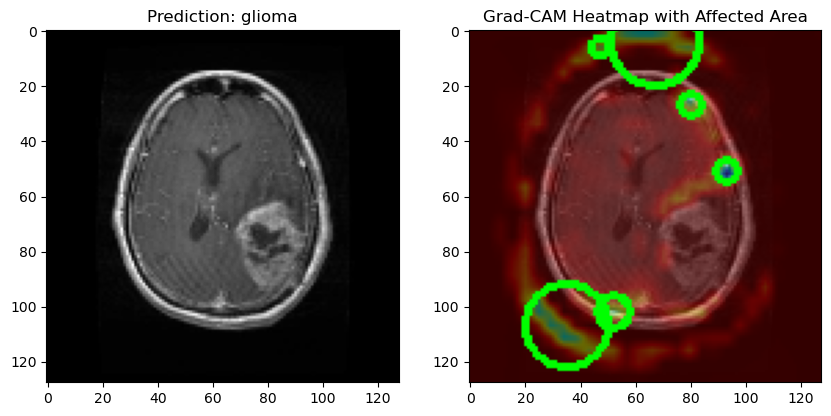

Suggested Action: Consult a medical professional for further guidance.
Predicted Diagnosis: glioma


1/1 [==============================] - 0s 34ms/step


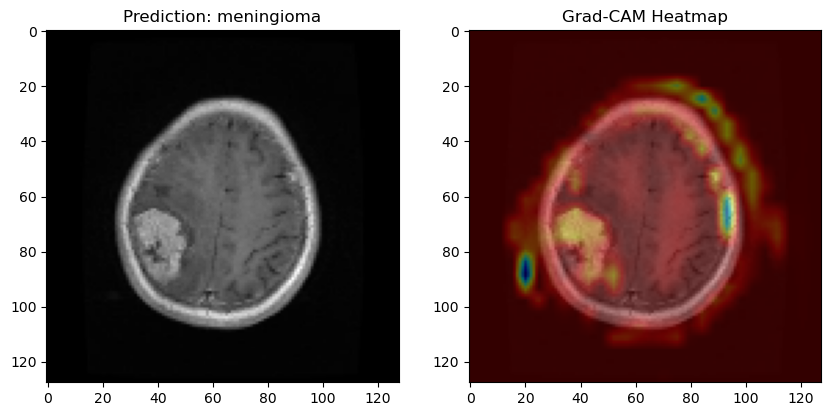

Suggested Action: Consult a medical professional for further guidance.
Predicted Diagnosis: meningioma


In [29]:
# Grad-CAM for visualization
def get_gradcam_heatmap(model, img_array, layer_name="conv2d_2"):
    grad_model = tf.keras.models.Model([model.input], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, np.argmax(predictions)]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)[0].numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

# Overlay heatmap without extra circles
def overlay_heatmap(original_img, heatmap):
    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_GRAY2RGB)  # Convert grayscale to RGB
    overlayed_img = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)
    return overlayed_img

# Prediction function with suggestions
def get_prediction(img_path):
    dicom_data = pydicom.dcmread(img_path)
    img = dicom_data.pixel_array
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img_array = np.expand_dims(img, axis=(0, -1))
    
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)
    diagnosis = class_labels[predicted_class]
    
    heatmap = get_gradcam_heatmap(model, img_array)
    heatmap_img = overlay_heatmap((img * 255).astype(np.uint8), heatmap)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Prediction: {diagnosis}")
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap_img)
    plt.title("Grad-CAM Heatmap")
    plt.show()
    
    # Provide suggestions
    suggestions = {
        "Glioma": "Consider consulting a neurologist for further assessment and possible treatment options.",
        "Meningioma": "Regular monitoring and medical consultation are recommended.",
        "No Tumor": "No immediate concerns detected, but maintain regular check-ups.",
        "Pituitary": "Check for hormonal imbalances and consult an endocrinologist."
    }
    print(f"Suggested Action: {suggestions.get(diagnosis, 'Consult a medical professional for further guidance.')}")
    
    return diagnosis

# Example usage
img_path = "Tr-me_0011.dcm"
prediction = get_prediction(img_path)
print(f"Predicted Diagnosis: {prediction}")